In [66]:
import tkinter as tk
from tkinter import simpledialog, messagebox
import pandas as pd
import numpy as np
import logging
from dataclasses import dataclass
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
from IPython.display import display, Markdown
import yfinance as yf
import matplotlib.pyplot as plt

import sys
sys.path.append(r"C:\Users\Ludovic\anaconda3\Lib\site-packages\pybacktestchain")

import data_module  
import broker
import pybacktestchain
import utils
import blockchain
from pybacktestchain.data_module import get_stocks_data, get_stock_data

def get_stock_data(ticker, start_date, end_date):
    """Retrieve historical stock data for a single ticker using yfinance."""
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, auto_adjust=False, actions=False)
        data['ticker'] = ticker
        data.reset_index(inplace=True)
        return data[['Date', 'ticker', 'Adj Close', 'Volume']]
    except Exception as e:
        logging.warning(f"Failed to fetch data for {ticker}: {e}")
        return pd.DataFrame()

def get_stocks_data(tickers, start_date, end_date):
    """Retrieve historical stock data for multiple tickers."""
    dfs = []
    
    for ticker in tickers:
        df = get_stock_data(ticker, start_date, end_date)
        if not df.empty:
            df = df[['Date', 'Adj Close']]  # Keep only 'Date' and 'Adj Close'
            df['Ticker'] = ticker  # Add a column for ticker
            dfs.append(df)
    
    # Combine all dataframes into one
    all_data = pd.concat(dfs)
    
    # Pivot the data so tickers are columns and dates are rows
    all_data = all_data.pivot(index='Date', columns='Ticker', values='Adj Close')
    
    # Drop rows with NaN values
    all_data = all_data.dropna(how='all')
    
    return all_data

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to get stock inputs
def get_stock_inputs():
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    num_stocks = simpledialog.askinteger("Number of Stocks", "How many stocks do you want to enter?")
    
    if not num_stocks or num_stocks <= 0:
        print("No stocks to enter.")
        return []

    root = tk.Tk()
    root.title("Enter Stock Names")
    entries = []
    stock_names = []

    def on_submit():
        nonlocal stock_names
        stock_names = [entry.get().strip().upper() for entry in entries]
        root.quit()
        root.destroy()

    for i in range(num_stocks):
        tk.Label(root, text=f"Stock {i+1}").pack(padx=10, pady=5)
        entry = tk.Entry(root)
        entry.pack(padx=10, pady=5)
        entries.append(entry)

    tk.Button(root, text="Submit", command=on_submit).pack(pady=10)
    root.mainloop()
    return stock_names

# Function to get date inputs via a userform
def get_date_inputs():
    def on_submit():
        nonlocal start_date, end_date
        start_date = start_date_entry.get()
        end_date = end_date_entry.get()

        try:
            # Validate the dates
            datetime.strptime(start_date, '%Y-%m-%d')
            datetime.strptime(end_date, '%Y-%m-%d')
            if start_date > end_date:
                raise ValueError("Start date must be before end date!")
            root.quit()
            root.destroy()
        except ValueError as e:
            messagebox.showerror("Invalid Input", f"Invalid date format or range: {e}")
    
    start_date = None
    end_date = None
    
    root = tk.Tk()
    root.title("Select Date Range")
    
    tk.Label(root, text="Start Date (YYYY-MM-DD):").pack(padx=10, pady=5)
    start_date_entry = tk.Entry(root)
    start_date_entry.pack(padx=10, pady=5)
    
    tk.Label(root, text="End Date (YYYY-MM-DD):").pack(padx=10, pady=5)
    end_date_entry = tk.Entry(root)
    end_date_entry.pack(padx=10, pady=5)
    
    tk.Button(root, text="Submit", command=on_submit).pack(pady=10)
    root.mainloop()
    
    return start_date, end_date

def plot_historical_prices(df):
    """
    Plots historical prices from a DataFrame where tickers are columns,
    and the index represents dates.
    """
    tickers = df.columns  # Use the columns as the tickers
    plt.figure(figsize=(12, 6))
    
    for ticker in tickers:
        plt.plot(df.index, df[ticker], label=ticker)
    
    plt.title("Historical Prices")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.show()


Data loaded successfully.


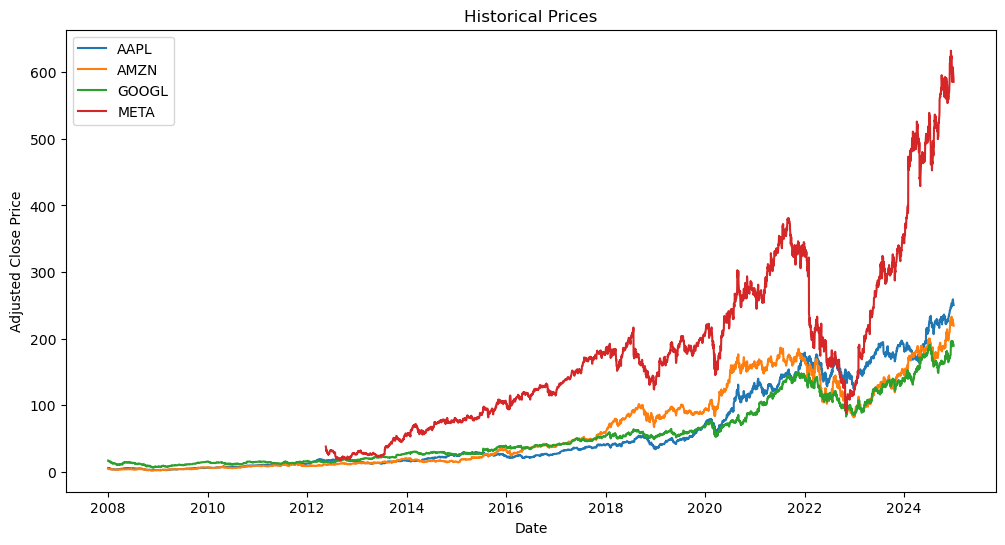

In [68]:
# Main execution flow
if __name__ == "__main__":
    # Step 1: Get stock tickers from the user
    tickers = get_stock_inputs()
    if not tickers:
        print("No tickers entered. Exiting...")
    else:
        # Step 2: Get date range from the user
        start_date, end_date = get_date_inputs()
        if not start_date or not end_date:
            print("No dates provided. Exiting...")
        else:
            # Step 3: Load historical data for the tickers
            all_data = get_stocks_data(tickers, start_date, end_date)
            if all_data.empty:
                print("No data retrieved for the entered tickers.")
            else:
                print("Data loaded successfully.")
                
                # Step 4: Plot historical prices
                plot_historical_prices(all_data)

In [10]:
all_data.tail()

Ticker,AAPL,AMZN,GOOGL,META
Date,,,,
2024-12-24 00:00:00-05:00,258.200012,229.050003,196.110001,607.750000
2024-12-26 00:00:00-05:00,259.019989,227.050003,195.600006,603.349976
2024-12-27 00:00:00-05:00,255.589996,223.750000,192.759995,599.809998
2024-12-30 00:00:00-05:00,252.199997,221.300003,191.240005,591.239990
2024-12-31 00:00:00-05:00,250.419998,219.389999,189.300003,585.510010


In [17]:
def sample_cov(prices, returns_data=False, frequency=252, log_returns=False, fix_method="spectral"):
    """
    Calculate the sample covariance matrix of returns and fix it if it's not positive semidefinite.
    """
    # Ensure input is a DataFrame
    prices = pd.DataFrame(prices) if not isinstance(prices, pd.DataFrame) else prices
    
    # Calculate returns if returns_data is False
    returns = prices if returns_data else returns_from_prices(prices, log_returns)
    
    # Compute covariance and fix non-positive semidefinite matrices
    cov_matrix = returns.cov() * frequency
    return cov_matrix if is_positive_semidefinite(cov_matrix) else fix_nonpositive_semidefinite(cov_matrix, fix_method)


def is_positive_semidefinite(matrix):
    """
    Check if a matrix is positive semidefinite using Cholesky decomposition.
    """
    try:
        np.linalg.cholesky(matrix + 1e-16 * np.eye(len(matrix)))
        return True
    except np.linalg.LinAlgError:
        return False


def fix_nonpositive_semidefinite(matrix, fix_method="spectral"):
    """
    Fix a non-positive semidefinite matrix (stub for now).
    """
    # You can implement specific fixes based on the method (e.g., spectral, nearest PSD matrix, etc.)
    return matrix

def returns_from_prices(prices, log_returns=False):
    if log_returns:
        returns = np.log(1 + prices.pct_change(fill_method=None)).dropna(how="all")
    else:
        returns = prices.pct_change(fill_method=None).dropna(how="all")
    return returns

In [19]:
sample_cov = sample_cov(all_data, frequency=252)
sample_cov

Ticker,AAPL,AMZN,GOOGL,META
Ticker,,,,
AAPL,0.095495,0.057852,0.053371,0.047481
AMZN,0.057852,0.136242,0.065535,0.064458
GOOGL,0.053371,0.065535,0.089434,0.058120
META,0.047481,0.064458,0.058120,0.158812


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """
    Plot the covariance or correlation matrix as a heatmap.
    """
    # Convert covariance matrix to correlation if required
    matrix = cov_to_corr(cov_matrix) if plot_correlation else cov_matrix

    # Create the heatmap
    fig, ax = plt.subplots()
    cax = ax.imshow(matrix, cmap='viridis')
    fig.colorbar(cax)

    # Configure tick labels
    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index, rotation=90)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)

    # Show the plot
    plt.show()

    return ax


In [23]:
def cov_to_corr(cov_matrix):
    if not isinstance(cov_matrix, pd.DataFrame):
        warnings.warn("cov_matrix is not a dataframe", RuntimeWarning)
        cov_matrix = pd.DataFrame(cov_matrix)

    Dinv = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
    corr = np.dot(Dinv, np.dot(cov_matrix, Dinv))
    return pd.DataFrame(corr, index=cov_matrix.index, columns=cov_matrix.index)


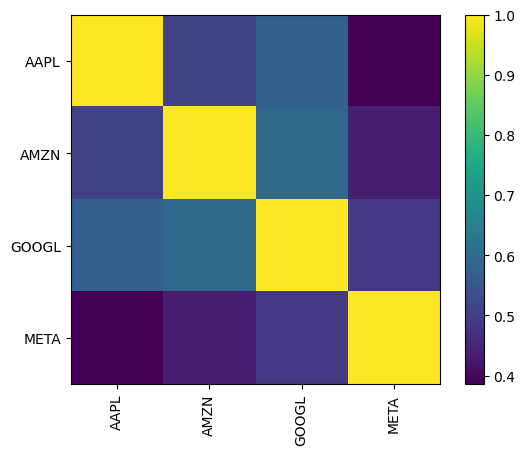

<Axes: >

In [25]:
plot_covariance(sample_cov, plot_correlation=True)

In [35]:
# Volatility minimization with return objective
def port_minvol_ro(expected_return, covariance_matrix, ro):
    """
    Minimize portfolio volatility for a target return.
    """
    def objective(W, R, C, ro):
        # Portfolio variance
        varp = np.dot(np.dot(W.T, C), W)
        return varp**0.5  # Minimize volatility
    
    n = len(covariance_matrix)
    W = np.ones([n]) / n  # Initial weights: equally distributed
    bounds = [(0., 1.) for _ in range(n)]  # No short selling
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1.},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda W: np.dot(W.T, expected_return) - ro}  # Target return
    ]
    
    optimized = opt.minimize(
        objective, W, (expected_return, covariance_matrix, ro),
        method='SLSQP', constraints=constraints, bounds=bounds,
        options={'maxiter': 100, 'ftol': 1e-08}
    )
    return optimized.x

# Volatility minimization
def port_minvol(expected_return, covariance_matrix):
    """
    Minimize portfolio volatility.
    """
    def objective(W, R, C):
        # Portfolio variance
        varp = np.dot(np.dot(W.T, C), W)
        return varp**0.5  # Minimize volatility
    
    n = len(covariance_matrix)
    W = np.ones([n]) / n  # Initial weights: equally distributed
    bounds = [(0., 1.) for _ in range(n)]  # No short selling
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}  # Weights sum to 1
    ]
    
    optimized = opt.minimize(
        objective, W, (expected_return, covariance_matrix),
        method='SLSQP', constraints=constraints, bounds=bounds,
        options={'maxiter': 100, 'ftol': 1e-08}
    )
    return optimized.x

# Return maximization
def port_maxret(expected_return, covariance_matrix):
    """
    Maximize portfolio return.
    """
    def objective(W, R, C):
        # Portfolio return
        meanp = np.dot(W.T, R)
        return -meanp  # Minimize negative return (maximize return)
    
    n = len(covariance_matrix)
    W = np.ones([n]) / n  # Initial weights: equally distributed
    bounds = [(0., 1.) for _ in range(n)]  # No short selling
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1.}  # Weights sum to 1
    ]
    
    optimized = opt.minimize(
        objective, W, (expected_return, covariance_matrix),
        method='SLSQP', constraints=constraints, bounds=bounds,
        options={'maxiter': 100, 'ftol': 1e-08}
    )
    return optimized.x


In [46]:
import tkinter as tk
from tkinter import simpledialog

def get_target_return():
    """
    Prompt the user to input a target return using a simple dialog box.
    Returns the target return as a float.
    """
    root = tk.Tk()
    root.withdraw()  # Hide the main Tkinter window
    target_return = simpledialog.askfloat(
        "Target Return", 
        "Enter the target return (e.g., 0.1 for 10%):",
        minvalue=0.0, maxvalue=1.0  # Optional bounds for input
    )
    root.destroy()  # Close the Tkinter window
    if target_return is None:
        raise ValueError("No target return provided!")
    return target_return

In [48]:
# Calculate the annualized expected returns and covariance matrix
returns = all_data.pct_change().dropna()  # Calculate percentage changes
expected_return = returns.mean() * 252  # Annualized mean returns
covariance_matrix = returns.cov() * 252  # Annualized covariance matrix

# Target return
target_return = get_target_return()

# Optimal portfolios
weights_minvol_ro = port_minvol_ro(expected_return.values, covariance_matrix.values, target_return)
weights_minvol = port_minvol(expected_return.values, covariance_matrix.values)
weights_maxret = port_maxret(expected_return.values, covariance_matrix.values)

print("Portfolio Weights (Min Vol with Target Return):", weights_minvol_ro)
print("Portfolio Weights (Min Vol):", weights_minvol)
print("Portfolio Weights (Max Return):", weights_maxret)


Portfolio Weights (Min Vol with Target Return): [8.86359529e-18 3.31619460e-22 1.00000000e+00 0.00000000e+00]
Portfolio Weights (Min Vol): [0.41149569 0.15126442 0.41374409 0.0234958 ]
Portfolio Weights (Max Return): [3.05311332e-16 0.00000000e+00 2.79652542e-16 1.00000000e+00]


In [60]:
def plot_weights(weights, tickers, ax=None, title="Portfolio Weights", **kwargs):
    """
    Plot portfolio weights as a horizontal bar chart.

    Parameters:
    - weights: 1D array of portfolio weights (e.g., [0.4, 0.3, 0.2, 0.1]).
    - tickers: List of asset tickers corresponding to the weights (e.g., ['AAPL', 'META']).
    - ax: Optional Matplotlib axis object.
    - title: Title of the plot (default: "Portfolio Weights").
    - **kwargs: Additional keyword arguments for customization.
    
    Returns:
    - ax: Matplotlib axis object.
    """
    ax = ax or plt.gca()  # Use provided axis or get the current one

    # Sort weights and tickers by weight (largest to smallest)
    desc = sorted(zip(tickers, weights), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in desc]
    vals = [i[1] for i in desc]

    # Positions for the bars
    y_pos = np.arange(len(labels))

    # Create horizontal bar chart
    ax.barh(y_pos, vals, color=kwargs.get('color', 'blue'))
    ax.set_xlabel("Weight", fontsize=12)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()  # Invert y-axis for descending order
    ax.set_title(title, fontsize=14)

    # Display the plot
    plt.show()

    return ax


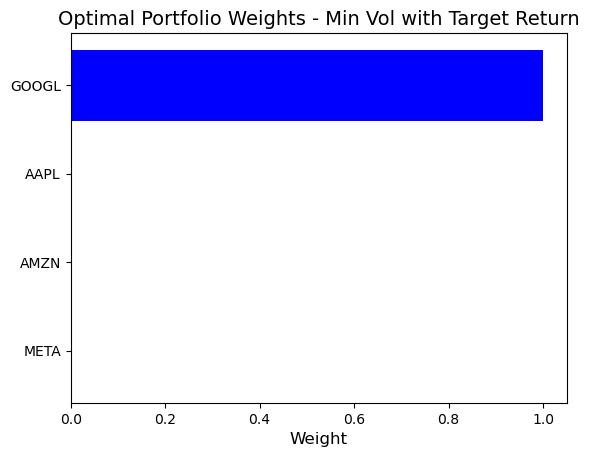

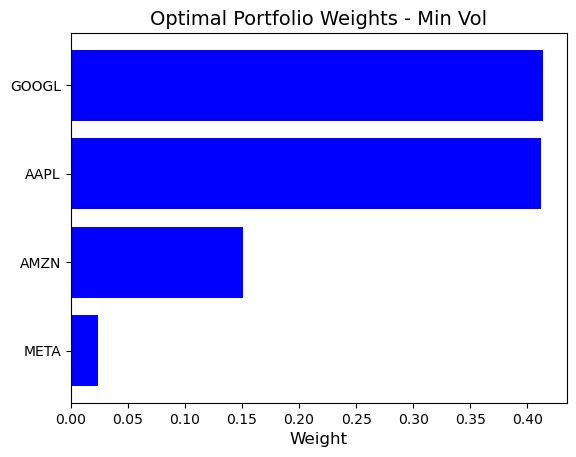

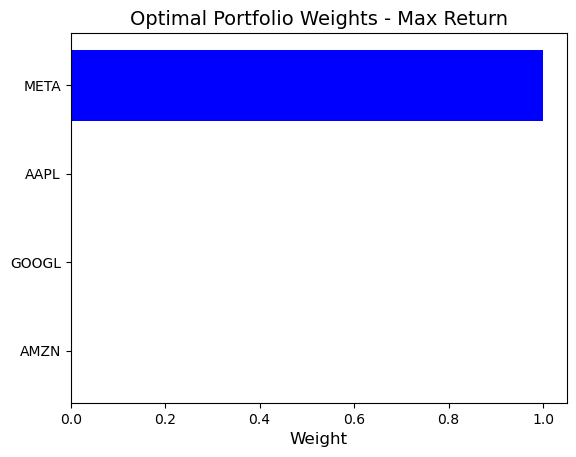

<Axes: title={'center': 'Optimal Portfolio Weights - Max Return'}, xlabel='Weight'>

In [64]:
# Plot weights for all portfolios
plot_weights(weights_minvol_ro, tickers=all_data.columns, title="Optimal Portfolio Weights - Min Vol with Target Return")
plot_weights(weights_minvol, tickers=all_data.columns, title="Optimal Portfolio Weights - Min Vol")
plot_weights(weights_maxret, tickers=all_data.columns, title="Optimal Portfolio Weights - Max Return")